# 07_Training a convnet from scratch on a small dataset

매우 적은 데이터를 사용하여 이미지 분류 모델을 훈련하는 일은 흔한 경우입니다. 보통 "적은" 샘플이란 수백 개에서 수만 개 사이를 의미합니다. 실용적인 예제로 강아지와 고양이사진으로 구성된 데이터셋에서 강아지와 고양이 이미지를 분류해 보겠습니다. 훈련을 위해 200개의 사진을 사용하고 검증과 테스트에 각각 100개의 사진을 사용합니다.  

보유한 데이터셋을 사용하여 처음부터 새로운 모델을 훈련하겠습니다. 200개의 훈련 샘플에서 작은 컨브넷을 어떤 규제 방법도 사용하지 않고 훈련하여 기준이 되는 기본 성능을 만들겠습니다. 그 다음 컴퓨터 비전에서 과대 적합을 줄이기 위한 강력한 방법인 데이터 증식(data argumentation)을 사용하겠습니다. 데이터 증식을 사용하면 모델의 성능을 향상시킬 것입니다.  

그다음으로 작은 데이터셋에 딥러닝을 적용하기 위한 핵심적인 기술 2가지를 더 알아보겠습니다. 사전 훈련된 네트워크로 특성을 추출하는 것과 사전 훈련된 네트워크를 세밀하게 튜닝하는 것입니다. 이런 전략은 작은 데이터셋에서 이미지 분류 문제를 수행할 때 포함되어 있어야 합니다.

## Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
from IPython.display import HTML

# Common imports
import numpy as np
import os
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import matplotlib.image as mpimg
def plot_external(img):
    img_name = os.path.join(".", "images",img)
    plots = mpimg.imread(img_name)
    plt.axis("off")
    plt.imshow(plots)    
    plt.show()
    
def plot_external2(imgpath):    
    plots = mpimg.imread(imgpath)
    plt.axis("off")
    plt.imshow(plots)    
    plt.show()  

# batch function
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

<br>

## 7.1 The relevance of deep learning for small-data problems

딥러닝은 데이터가 풍부할 때만 작동한다는 말이 있지만 꼭 그런 것은 아닙니다. 딥러닝의 근본적인 특징은 훈련 데이터에서 특성 공학의 수작업 없이 흥미로운 특성을 찾을 수 있는 것입니다. 이는 훈련 샘플이 많아야만 가능합니다. 입력 샘플이 이미지처럼 매우 고차원적인 문제에서는 특히 그렇습니다.  

하지만 많은 샘플이 의미하는 것은 상대적입니다. 우선 훈련하려는 네트워크의 크기와 깊이에 상대적입니다. 복잡한 문제를 푸는 컨브넷을 수십 개의 샘플만 사용해서 훈련하는 것은 불가능합니다. 하지만 모델이 작고 규제가 잘 되어 있으며 간단한 작업이라면 수백 개의 샘플로도 충분할 수 있습니다. 컨브넷은 지역적이고 평행 이동으로 편하지 않는 특성을 학습하기 때문에 지각에 관한 문제에서 매우 효율적으로 데이터를 사용합니다. 매우 작은 이미지 데이터셋에서 어떤 종류의 특성 공학을 사용하지 않고 컨브넷을 처음부터 훈련해도 납득할 만한 결과를 만들 수 있습니다.  

거기에 더하여 딥러닝 모델은 매우 다목적입니다. 말하자면 대규모 데이터셋에서 훈련시킨 이미지 분류모델이나 speech-to-text 모델을 조금만 변경해서 완전히 다른 문제에 재사용할 수 있습니다. 특히 컴퓨터 비전에서는 사전 훈련된 모델들이 내려받을 수 있도록 많이 공개되어 있어서 매우 적은 데이터에서 강력한 비전 모델을 만드는데 사용할 수 있습니다.

<br>

## 7.2 Preparing the data

컨브넷이 주류가 되기 전인 2013년 후반에 kaggle에서 컴퓨터 비전 경연 대회의 일환으로 이 데이터셋을 만들었습니다. 이 사진들은 중간 정도의 해상도를 가진 컬러 JPEG파일이며 그 샘플들은 아래와 같습니다.

In [ ]:
plt.figure(figsize=(12, 7))
plt.title("강아지 vs 고양이, 이 샘플들은 원본 크기 그대로이며, 샘플들은 사이즈와 모습 등이 제각각임", fontsize=14)
plot_external2("./images/ch07/1.png")
plt.show()

이 데이터셋은 2만 5000개의 이미지를 담고 있습니다. 이 데이터를 3개의 서브셋이 들어있는 새로운 데이터셋을 만들 것입니다. 클래스마다 500개의 샘플로 이루어진 훈련 세트, 클래스마다 250개의 샘플로 이루어진 검증 세트, 클래스마다 250개이 샘플로 이루어진 테스트 세트입니다.

In [2]:
import os, shutil

In [3]:
def makedir(path):
    if not os.path.isdir(path):
        os.makedirs(path)
        print("directory created!!")
    else:
        print("directory exist!!")

In [4]:
original_dataset_dir = "./datasets/dogs-vs-cats/train/" # 원본 데이터 디렉터리
base_dir = "./datasets/dogs_and_cats_small" # 소규모 데이터셋 디렉터리

makedir(base_dir)    

directory exist!!


In [5]:
# 훈련/검증/테스트 분할을 위한 디렉터리
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

dirs = [train_dir, validation_dir, test_dir]
for d in dirs:
    makedir(d)

directory exist!!
directory exist!!
directory exist!!


In [6]:
# 훈련용 사진 디렉터리
train_cats_dir = os.path.join(train_dir, "cats")
train_dogs_dir = os.path.join(train_dir, "dogs")

dirs = [train_cats_dir, train_dogs_dir]
for d in dirs:
    makedir(d)

directory exist!!
directory exist!!


In [7]:
# 검증용 사진 디렉터리
validation_cats_dir = os.path.join(validation_dir, "cats")
validation_dogs_dir = os.path.join(validation_dir, "dogs")

dirs = [validation_cats_dir, validation_dogs_dir]
for d in dirs:
    makedir(d)

directory exist!!
directory exist!!


In [8]:
# 테스트용 사진 디렉터리
test_cats_dir = os.path.join(test_dir, "cats")
test_dogs_dir = os.path.join(test_dir, "dogs")

dirs = [test_cats_dir, test_dogs_dir]
for d in dirs:
    makedir(d)

directory exist!!
directory exist!!


<br>

> 이미지 복사

In [57]:
# 이미지가 있으면 삭제
target_directories = [train_cats_dir, train_dogs_dir, 
                      validation_cats_dir, validation_dogs_dir,
                      test_cats_dir, test_dogs_dir]
for t in target_directories:
    if os.path.exists(t):
        for f in os.listdir(t):        
            dst = os.path.join(t, f)
            try: 
                os.remove(dst)
            except:
                shutil.rmtree(dst, ignore_errors=True)

In [60]:
# 고양이 사진 복사
fnames = ["cat.{}.jpg".format(i) for i in range(500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)    
    shutil.copyfile(src, dst)

fnames = ["cat.{}.jpg".format(i) for i in range(500, 750)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ["cat.{}.jpg".format(i) for i in range(750, 1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)    
    
# 강아지 사진 복사
fnames = ["dog.{}.jpg".format(i) for i in range(500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ["dog.{}.jpg".format(i) for i in range(500, 750)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ["dog.{}.jpg".format(i) for i in range(750, 1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)    

<br>

> 복사가 잘 되었는지 확인

In [61]:
print("훈련용 고양이 이미지 전체 갯수: {}".format(len(os.listdir(train_cats_dir))))
print("훈련용 강아지 이미지 전체 갯수: {}".format(len(os.listdir(train_dogs_dir))))
print("검증용 고양이 이미지 전체 갯수: {}".format(len(os.listdir(validation_cats_dir))))
print("검증용 강아지 이미지 전체 갯수: {}".format(len(os.listdir(validation_dogs_dir))))
print("테스트 고양이 이미지 전체 갯수: {}".format(len(os.listdir(test_cats_dir))))
print("테스트 강아지 이미지 전체 갯수: {}".format(len(os.listdir(test_dogs_dir))))

훈련용 고양이 이미지 전체 갯수: 500
훈련용 강아지 이미지 전체 갯수: 500
검증용 고양이 이미지 전체 갯수: 250
검증용 강아지 이미지 전체 갯수: 250
테스트 고양이 이미지 전체 갯수: 250
테스트 강아지 이미지 전체 갯수: 250


이제 200개의 훈련이미지, 50개의 검증 이미지, 50개의 테스트 이미지가 준비되었습니다. 분할된 각 데이터는 클래스마다 동일한 갯수의 샘플을 포함합니다. 균형 잡힌 이진 분류 문제이므로 정확도를 사용하여 성공을 측정하겠습니다.


<br>

## 7.3 Building your network

Conv2D(relu 활성화 함수 사용)와 MaxPooling2D 층을 번갈아 쌓은 컨브넷을 만들겠습니다.  

이미지가 크고 복잡한 문제이기 때문에 네트워크를 좀 더 크게 만들겠습니다.  
Conv2D + MaxPooling2D 단계를 하나 더 추가합니다. 이렇게 하면 네트워크의 용량을 늘리고 Flatten 층의 크기가 너무 너무 커지지 않도록 특성 맵의 크기를 줄일 수 있습니다. 150X150 크기(임의로 선택한 것)의 입력으로 시적해서 Flatten 층 이전에 7x7 크기의 특성 맵으로 줄어듭니다.  

이진 분류 문제이므로 네트워크는 하나의 유닛(크기가 1인 Dense층)과 sigmoid 활성화 함수로 끝납니다. 이 유닛은 한 클래스에 대한 확률을 인코딩합니다.

In [62]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [63]:
tf.keras.backend.clear_session()
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)))
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation="relu"))
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation="relu"))
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

W0802 18:24:42.432423 139772909860672 deprecation.py:506] From /opt/conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [64]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

<br>

컴파일 단계에서는 Adam 옵티마이저를 선택하겠습니다. 네트워크의 마지막이 하나의 시그모이드 유닛이기 때문에 binary crossentropy를 손실로 사용합니다.

In [65]:
from tensorflow.keras import optimizers, losses, metrics

In [66]:
model.compile(optimizer=optimizers.Adam(lr=1e-4), 
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

W0802 18:24:48.979452 139772909860672 deprecation.py:323] From /opt/conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [67]:
class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs):
        self.epochs = epochs
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch                
              
    def on_train_batch_end(self, batch, logs=None):        
        print('\repoch: {}, loss {:.5f}'.format(self.epoch+1, logs['loss']), end=" ")
              
    def on_epoch_end(self, epoch, logs=None):        
        if epoch == 0:
            print("\nhistory key: {}".format(list(logs.keys())))

        if (epoch+1) % 5 == 0 or epoch+1 == self.epochs:
            print("\rEpoch {}/{}".format(epoch+1, self.epochs), end=" ")
            print("loss: {:.5f}".format(logs["loss"]), end=" ")
            print("acc: {:.5f}".format(logs["binary_accuracy"]), end=" ")
            print("val_loss: {:.5f}".format(logs["val_loss"]), end=" ")
            print("val_acc: {:.5f}".format(logs["val_binary_accuracy"]))

<br>

## 7.4 Data preprocessing

데이터는 네트워크에 주입되기 전에 부동 소수 타입이 텐서로 전처리되어 있어야 합니다. 지금은 데이터가 JPEG파일로 되어 있으므로 네트워크에 주입하려면 대략 다음과정을 따릅니다.  

- 사진파일을 읽습니다.  
- JPEG 콘텐츠를 RGB픽셀값으로 디코딩합니다.  
- 그다음 부동 소수 타입의 텐서로 변환합니다.  
- 픽셀 값(0에서 255사이)의 스케일을 [0,1]사이로 조정합니다(신경망은 작은 입력 값을 선호합니다).  

케라스에서는 이런 단계를 처리하는 유틸리티가 있습니다.

In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [69]:
# 이미지를 1/255로 스케일을 조정
train_datagenerator = ImageDataGenerator(rescale=1./255)
test_datagenerator = ImageDataGenerator(rescale=1./255)

In [70]:
train_generator = train_datagenerator.flow_from_directory(
    train_dir, # 타깃디렉터리
    target_size=(150, 150), # 모든 이미지를 150x150 크기로 바꿉니다.
    batch_size=20,
    class_mode = "binary" # binary, sparse(정수 레이블을 담은 1차원 배열을 리턴), categorical(원핫인코딩 된 2차원 배열을 리턴)
)

Found 1000 images belonging to 2 classes.


In [71]:
validation_generator = test_datagenerator.flow_from_directory(
    validation_dir, # 타깃디렉터리
    target_size=(150, 150), # 모든 이미지를 150x150 크기로 바꿉니다.
    batch_size=20,
    class_mode = "binary" # binary, sparse(정수 레이블을 담은 1차원 배열을 리턴), categorical(원핫인코딩 된 2차원 배열을 리턴)
)

Found 500 images belonging to 2 classes.


<br>

이 제너레이터의 출력 하나를 살펴보겠습니다. 이 출력은 150x150 RGB 이미지의 배치(20, 150, 150, 3)크기와  이진 레이블의 배치((20, ) 크기)입니다. 각 배치에는 20개의 샘플(배치 크기)이 있습니다. 제너레이터는 이 배치를 무한정 만들어 냅니다. 타깃 폴더에 있는 이미지를 끝없이 반복합니다. 따라서 break문을 사용해서 중간에 일시정지 해야합니다.

In [72]:
for data_batch, labels_batch in train_generator:
    print("배치 데이터 크기: {}".format(data_batch.shape))
    print("배치 레이블 크기: {}".format(labels_batch.shape))
    break

배치 데이터 크기: (20, 150, 150, 3)
배치 레이블 크기: (20,)


<br>

제너레이터를 사용한 데이터에 모델을 훈련시켜 보겠습니다. fit_generator 메서드는 fit 메서드와 동일하지만 데이터 제너레이터를 사용할 수 있습니다. 이 메서드는 첫 번째 매개변수로 입력과 타깃의 배치를 끝없이 반환하는 파이썬 제너레이터를 사용합니다. 데이터가 끝없이 생성되기 때문에 케라스 모델에 하나의 에포크를 정의하기 위해 재러네이터로부터 얼마나 많은 샘플을 뽑을 것인지 알려주어야 합니다. steps_per_epoch 매개변수에서 이를 설정합니다. 제너레이터로부터 steps_per_epoch개의 배치만큼 뽑은 후 즉 steps_per_epoch 횟수만큼 경사하강법 단계를 실행한 후에 훈련 프로세스는 다음 에포크로 넘어갑니다. 여기서는 20개의 샘플이 하나의 배치이므로 1000개의 샘플을 모두 처리할때까지 50개의 배치를 뽑을 것입니다.  

fit_generator를 사용할 때 fit 매서드와 마찬가지로 validation_data 매개변수를 전달할 수 있습니다. 이 매개변수에는 데이터 재너레이터도 가능하지만 넘파이 배열의 튜플도 가능합니다. validation_data로 제너레이터를 전달하면 검증 데이터의 배치를 끝없이 반환합니다 따라서 검증 데이터 제너레이터에서 알마나 많은 배치를 추출하여 평가할지 validation_steps 매개변수에 지정해야합니다.  

validation_generator의 배치가 20개로 지정되었으므로 전체 검증 데이터 500개를 사용하려면 validation_steps를 25로 설정합니다.

In [73]:
n_epoch = 30

In [74]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=n_epoch,
    validation_data=validation_generator,
    validation_steps=25,
    verbose=0,
    callbacks=[LossAndErrorPrintingCallback(n_epoch)])

epoch: 1, loss 0.66644 
history key: ['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy']
Epoch 5/30 loss: 0.56688 acc: 0.71700 val_loss: 0.61053 val_acc: 0.65800
Epoch 10/30 loss: 0.33312 acc: 0.86600 val_loss: 0.68405 val_acc: 0.70000
Epoch 15/30 loss: 0.17852 acc: 0.94100 val_loss: 0.74975 val_acc: 0.70800
Epoch 20/30 loss: 0.08545 acc: 0.98000 val_loss: 0.98422 val_acc: 0.68400
Epoch 25/30 loss: 0.03375 acc: 0.99600 val_loss: 1.07661 val_acc: 0.69200
Epoch 30/30 loss: 0.00978 acc: 1.00000 val_loss: 1.31522 val_acc: 0.69600


In [78]:
makedir("models/ch7_small_data")
model.save("models/ch7_small_data/cats_and_dogs_small_1.h5")

directory exist!!


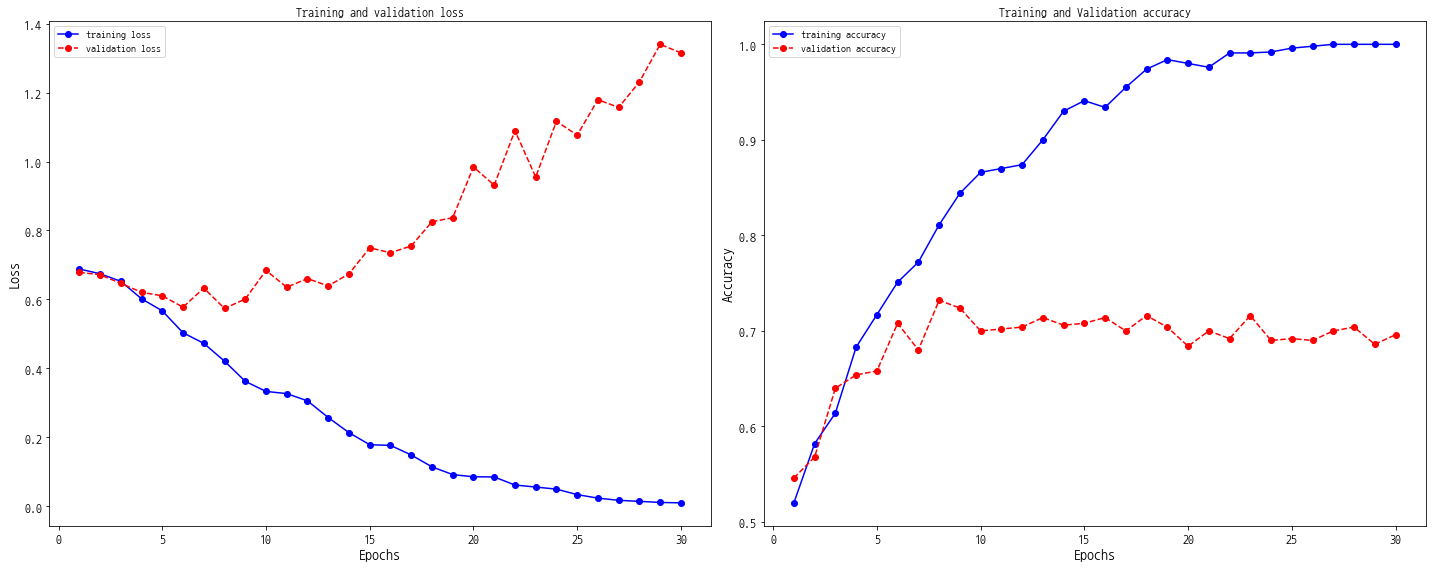

In [79]:
# ['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy']
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

acc = history_dict["binary_accuracy"]
val_acc = history_dict["val_binary_accuracy"]

epochs = range(1, len(loss)+1)

plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.plot(epochs, loss, "bo-", label="training loss")
plt.plot(epochs, val_loss, "ro--", markerfacecolor="red", markeredgecolor="red", label="validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, "bo-", label="training accuracy")
plt.plot(epochs, val_acc, "ro--", markerfacecolor="red", markeredgecolor="red", label="validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation accuracy")
plt.legend()

plt.tight_layout()
plt.show()

이 그래프는 과대적합의 특성을 보여줍니다. 훈련 정확도가 시간이 지남에 따라 선형적으로 증가하에서 거의 100%에 도달합니다. 반면에 검증정확도는 70~72%에서 멈추었습니다. 검증 손실은 다섯 번의 에포크만에 최솟값에 다다른 이후 더이상 진전되지 않았습니다. 반면에 훈련 손실을 거의 0에 도달할 때까지 선형적으로 계속 감소합니다.  

비교적 훈련 샘플의 수(1,000개)가 적기 때문에 과대적합이 가장 중요한 문제입니다. 드롭아웃이나 가중치 감소(L2규제)처럼 과대적합을 감소시킬 수 있는 여러 가지 기법들을 활용할 수 있습니다.
이번에는 컴퓨터 비전에 특화되어 있어서 딥러닝으로 이미지를 다룰 때 매우 일반적으로 사용되는 새로운 방법인 데이터 증식을 시도해 보겠습니다.